<h1>Concrete Data Analysis</h1>
In this dataset, I've taken what I have and run every conceivable query against the data I have.  I have calculated costs on global average commodity prices.  I classified the concrete and stored the data into a local SQLite database and ran SQL queries against the data.

I am no expert in concrete, I just picked the dataset and began working on analyzing the data.

Should you have more information, or would like to contribute to my concrete knowledge, please feel free to do so.

If you have any questions, please contact me.

This will be in view only mode on my website, but invterviewers or potential employers will have access to my CV to find links to my work.

In [1]:
import pandas as pd #to manipulate the data
import sqlite3 #to connect to the database

# Let's get the CSV file into Jupyter and manipulate it using pandas
concrete_file = 'concrete.csv' 
df = pd.read_csv(concrete_file)

#Let's connect to my SQLite database
concretedatabase = 'C:/sqlite/concretedatabase.db'  
conn = sqlite3.connect(concretedatabase)

# Here I write the DataFrame to an SQLite table
df.to_sql('concrete', conn, index=False, if_exists='replace')

# Let's check if the data has been imported properly
query = "SELECT * FROM concrete LIMIT 5;"
result = pd.read_sql_query(query, conn)
print(result)

# Close the DB connection
conn.close()


   cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29  


<h2>What Kind Of Content Do We Have?</h2>
We run the query to see what each column holds

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect(concretedatabase)

# Query to get column names and their data types
data_types_query = "PRAGMA table_info(concrete);"

# Execute the query and fetch the results
data_types_result = pd.read_sql_query(data_types_query, conn)

# Display the result
print(data_types_result)

# Close the connection
conn.close()


   cid          name     type  notnull dflt_value  pk
0    0        cement     REAL        0       None   0
1    1          slag     REAL        0       None   0
2    2           ash     REAL        0       None   0
3    3         water     REAL        0       None   0
4    4  superplastic     REAL        0       None   0
5    5     coarseagg     REAL        0       None   0
6    6       fineagg     REAL        0       None   0
7    7           age  INTEGER        0       None   0
8    8      strength     REAL        0       None   0


<h2>Let's See If We Need To Clean The Data!</h2>
Hopefully our data is clean and we can get to work quickly.  If not, it can take a couple of hours to get it sorted. Lets Query the Data now........

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect(concretedatabase)

# Check for missing or erroneous data
missing_data_query = "SELECT COUNT(*) AS MissingValues FROM concrete WHERE " + " OR ".join([f"{col} IS NULL" for col in df.columns]) + ";"
missing_data_result = pd.read_sql_query(missing_data_query, conn)
print("Missing Data:")
print(missing_data_result)

# Check for incorrect values in each column
for col in df.columns:
    incorrect_values_query = f"SELECT COUNT(*) AS IncorrectValues FROM concrete WHERE NOT ({col} IS NULL OR {col} {'' if df[col].dtype == 'object' else 'BETWEEN ' + str(df[col].min()) + ' AND ' + str(df[col].max())});"
    incorrect_values_result = pd.read_sql_query(incorrect_values_query, conn)
    print(f"\nIncorrect Values for {col}:")
    print(incorrect_values_result)

# Check for incorrect data types in each column
incorrect_datatypes_query = "PRAGMA foreign_key_list(concrete);"
incorrect_datatypes_result = pd.read_sql_query(incorrect_datatypes_query, conn)
print("\nIncorrect Data Types:")
print(incorrect_datatypes_result)

# Close the connection
conn.close()


Missing Data:
   MissingValues
0              0

Incorrect Values for cement:
   IncorrectValues
0                0

Incorrect Values for slag:
   IncorrectValues
0                0

Incorrect Values for ash:
   IncorrectValues
0                0

Incorrect Values for water:
   IncorrectValues
0                0

Incorrect Values for superplastic:
   IncorrectValues
0                0

Incorrect Values for coarseagg:
   IncorrectValues
0                0

Incorrect Values for fineagg:
   IncorrectValues
0                0

Incorrect Values for age:
   IncorrectValues
0                0

Incorrect Values for strength:
   IncorrectValues
0                0

Incorrect Data Types:
Empty DataFrame
Columns: [id, seq, table, from, to, on_update, on_delete, match]
Index: []


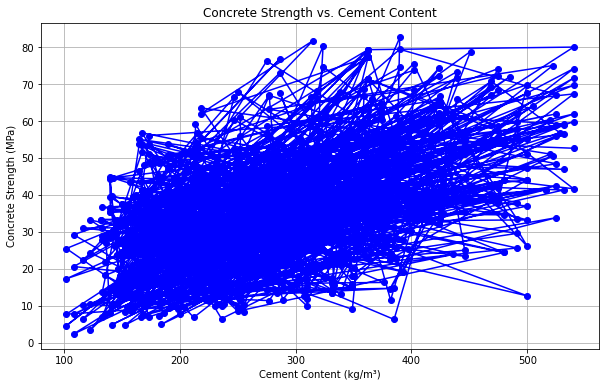

In [4]:
import matplotlib.pyplot as plt #to create charts and graphs
import sqlite3 #to connect to database

# Connect to the SQLite database
conn = sqlite3.connect(concretedatabase)

# Query to fetch data for the line chart
query = "SELECT cement, strength FROM concrete;"
data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(data['cement'].values, data['strength'].values, marker='o', linestyle='-', color='b')
plt.title('Concrete Strength vs. Cement Content')
plt.xlabel('Cement Content (kg/m³)')
plt.ylabel('Concrete Strength (MPa)')
plt.grid(True)
plt.show()


<h3>That looks too busy!</h3>
Let's try create something more appealing to the eye...........

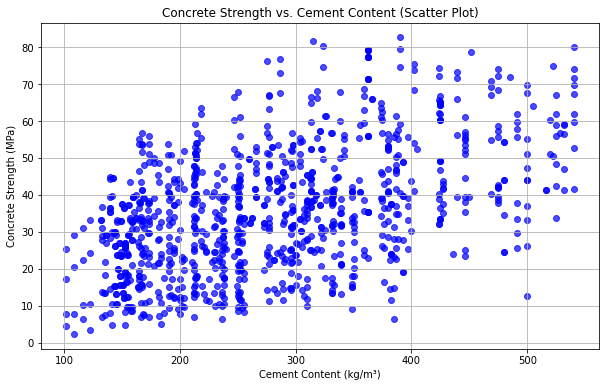

In [5]:
import matplotlib.pyplot as plt #to create our graphics
import sqlite3 #connect to DB

# Connect to the SQLite database
conn = sqlite3.connect(concretedatabase)

# Query to fetch data for the scatter plot
query = "SELECT cement, strength FROM concrete;"
data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['cement'].values, data['strength'].values, color='b', alpha=0.7)
plt.title('Concrete Strength vs. Cement Content (Scatter Plot)')
plt.xlabel('Cement Content (kg/m³)')
plt.ylabel('Concrete Strength (MPa)')
plt.grid(True)
plt.show()


<h4>That Looks better!</h4>

<h2>Let's Set Costs For The Ingredients</h2>
I did some reesearch and found global average prices for all ingredients by the tonne, except for water which is measured in 200m cubed, I will convert his into litres later on - I create anew column "cost_per_mix"

In [6]:
# Provided costs per metric tonne
costs_per_tonne = {
    'cement': 130.00,
    'slag': 120.00,
    'ash': 110.00,
    'water': 500.00,  # cost for 200 cubic meters
    'superplasticizers': 1300.00,
    'fineagg': 13.00,
    'coarseagg': 13.00
}

# Connect to the SQLite database
conn = sqlite3.connect(concretedatabase)

# Query to fetch data for the cost calculation
query = "SELECT * FROM concrete;"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Calculate the cost for each mix
df['cost_per_mix'] = (
    df['cement'] * costs_per_tonne['cement'] +
    df['slag'] * costs_per_tonne['slag'] +
    df['ash'] * costs_per_tonne['ash'] +
    df['superplastic'] * costs_per_tonne['superplasticizers'] +
    df['fineagg'] * costs_per_tonne['fineagg'] +
    df['coarseagg'] * costs_per_tonne['coarseagg']
)

# Water cost is calculated separately
df['cost_per_mix'] += costs_per_tonne['water'] * (df['water'] / 1000)  # Convert water from liters to cubic meters

# Display the DataFrame with the new 'cost_per_mix' column
print(df[['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg', 'cost_per_mix']])


      cement   slag    ash  water  superplastic  fineagg  coarseagg  \
0      141.3  212.0    0.0  203.5           0.0    748.5      971.8   
1      168.9   42.2  124.3  158.3          10.8    796.2     1080.8   
2      250.0    0.0   95.7  187.4           5.5    861.2      956.9   
3      266.0  114.0    0.0  228.0           0.0    670.0      932.0   
4      154.8  183.4    0.0  193.3           9.1    696.7     1047.4   
...      ...    ...    ...    ...           ...      ...        ...   
1025   135.0    0.0  166.0  180.0          10.0    805.0      961.0   
1026   531.3    0.0    0.0  141.8          28.2    893.7      852.1   
1027   276.4  116.0   90.3  179.6           8.9    768.3      870.1   
1028   342.0   38.0    0.0  228.0           0.0    670.0      932.0   
1029   540.0    0.0    0.0  173.0           0.0    613.0     1125.0   

      cost_per_mix  
0         66274.65  
1         79214.15  
2         73906.00  
3         69200.00  
4         76731.95  
...            ...  


<h2>Is there any correlation between cement content and concrete strength?</h2>
There is, we're just starting to ask the question now, but there is a load more data to see below

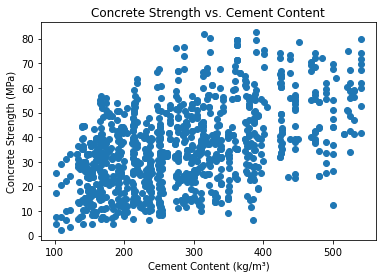

In [7]:
import matplotlib.pyplot as plt #to create our graph

# Scatter plot for Cement vs. Strength
plt.scatter(df['cement'], df['strength'])
plt.title('Concrete Strength vs. Cement Content')
plt.xlabel('Cement Content (kg/m³)')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


In [8]:
correlation_matrix = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg', 'age', 'strength']].corr()
print(correlation_matrix['strength'])


cement          0.497832
slag            0.134829
ash            -0.105755
water          -0.289633
superplastic    0.366079
fineagg        -0.167241
coarseagg      -0.164935
age             0.328873
strength        1.000000
Name: strength, dtype: float64


In [9]:
from sklearn.linear_model import LinearRegression #to do comparitive calculations

#list our ingredients to compare
X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg', 'age']]
y = df['strength'] #what we're comparing against

#show the calculation results
model = LinearRegression().fit(X, y)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [ 0.11980433  0.10386581  0.08793432 -0.14991842  0.2922246   0.02019035
  0.01808621  0.11422207]
Intercept: -23.331213584903665


<h3>Taking the Cement Content in Concrete Further</h3>
Here's a visual to show how the higher concentration of cement does affect the strength of our concrete

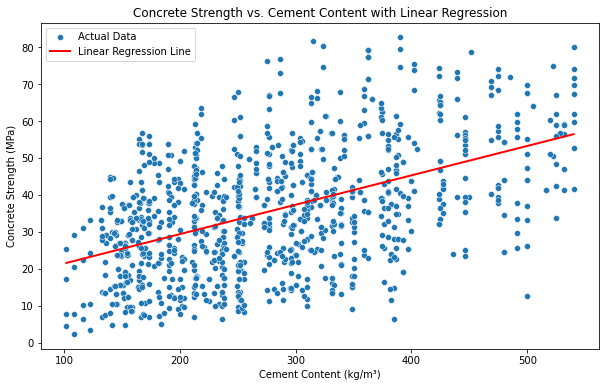

In [10]:
import matplotlib.pyplot as plt #to create the graph
import seaborn as sns #to add the linear regression graphic
import numpy as np #to perform calculations
from sklearn.linear_model import LinearRegression #to do comparitive calculations

# Create a linear regression model
X = df[['cement']].values  # Use .values to convert to a numpy array
y = df['strength'].values
model = LinearRegression().fit(X, y)

# Scatter plot for Cement vs. Strength
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cement', y='strength', data=df, label='Actual Data')
plt.title('Concrete Strength vs. Cement Content with Linear Regression')
plt.xlabel('Cement Content (kg/m³)')
plt.ylabel('Concrete Strength (MPa)')

# Plot the regression line
cement_range = np.linspace(df['cement'].min(), df['cement'].max(), 100).reshape(-1, 1)
plt.plot(cement_range, model.predict(cement_range), color='red', linewidth=2, label='Linear Regression Line')
plt.legend()

plt.show()


In [11]:
correlation_matrix = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg', 'age', 'strength']].corr()
print(correlation_matrix['strength'])


cement          0.497832
slag            0.134829
ash            -0.105755
water          -0.289633
superplastic    0.366079
fineagg        -0.167241
coarseagg      -0.164935
age             0.328873
strength        1.000000
Name: strength, dtype: float64


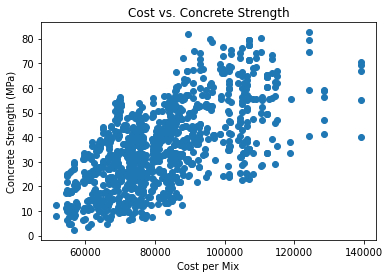

In [12]:
plt.scatter(df['cost_per_mix'], df['strength'])
plt.title('Cost vs. Concrete Strength')
plt.xlabel('Cost per Mix')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


In [13]:
X_cost = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg', 'age']]
y_cost = df['cost_per_mix']

model_cost = LinearRegression().fit(X_cost, y_cost)
print("Coefficients:", model_cost.coef_)
print("Intercept:", model_cost.intercept_)


Coefficients: [ 1.30000000e+02  1.20000000e+02  1.10000000e+02  5.00000000e-01
  1.30000000e+03  1.30000000e+01  1.30000000e+01 -2.27373675e-13]
Intercept: 5.966285243630409e-10


In [14]:
cost_bins = [0, 100, 200, 300, 400, 500]  # Adjust bins based on your data
df['cost_category'] = pd.cut(df['cost_per_mix'], bins=cost_bins)
strength_by_cost_category = df.groupby('cost_category')['strength'].mean()
print(strength_by_cost_category)


cost_category
(0, 100]     NaN
(100, 200]   NaN
(200, 300]   NaN
(300, 400]   NaN
(400, 500]   NaN
Name: strength, dtype: float64


In [15]:
from scipy.optimize import minimize #let's get the most cost effective mix

# Let's define the cost to minimize
def cost_function(x):
    return x[0] * costs_per_tonne['cement'] + x[1] * costs_per_tonne['slag'] + x[2] * costs_per_tonne['ash'] + \
           x[3] * costs_per_tonne['water'] + x[4] * costs_per_tonne['superplasticizers'] + \
           x[5] * costs_per_tonne['fineagg'] + x[6] * costs_per_tonne['coarseagg']

# Set constraints
total_volume = 1000 #priced as cost per unit which is 1000 
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - total_volume})

# Initial guess for variables
initial_guess = np.ones(len(costs_per_tonne))

# Minimize the cost function
result = minimize(cost_function, initial_guess, constraints=constraints)
optimized_mix = result.x

# Here's the optimized mix
print("Here's the most cost efficient conctrete mix:")
for i, component in enumerate(costs_per_tonne.keys()):
    print(f"{optimized_mix[i]:.2f} x {component}")


Here's the most cost efficient conctrete mix:
207330044565939392.00 x cement
224748065493657632.00 x slag
246228263520630912.00 x ash
-318900919444061120.00 x water
-1695598405442192896.00 x superplasticizers
667795746552200448.00 x fineagg
668397194016408576.00 x coarseagg


In [16]:
X_cost = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg', 'age']]
y_cost = df['cost_per_mix']

model_cost = LinearRegression().fit(X_cost, y_cost)
print("Coefficients:", model_cost.coef_)
print("Intercept:", model_cost.intercept_)


Coefficients: [ 1.30000000e+02  1.20000000e+02  1.10000000e+02  5.00000000e-01
  1.30000000e+03  1.30000000e+01  1.30000000e+01 -1.24344979e-13]
Intercept: -3.2014213502407074e-10


<h2>Is there a correlation between concrete age and strength?</h2>
We all kow that eventually concrete crumbles, but it can take a long time before it does so.  Let's have a look at what the data tells us about concrete and age

In [17]:
correlation_age_strength = df[['age', 'strength']].corr()
print(correlation_age_strength)


               age  strength
age       1.000000  0.328873
strength  0.328873  1.000000


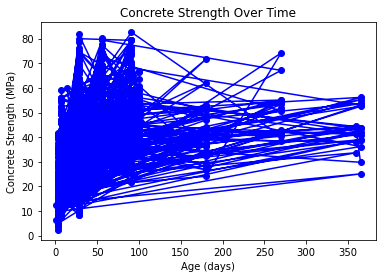

In [18]:
plt.plot(df['age'].values, df['strength'].values, marker='o', linestyle='-', color='b')
plt.title('Concrete Strength Over Time')
plt.xlabel('Age (days)')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


In [19]:
age_bins = [0, 30, 60, 90, 120, 150]  #We break our age up into 30 day periods
df['age_category'] = pd.cut(df['age'].values, bins=age_bins)
strength_by_age_category = df.groupby('age_category')['strength'].mean().values
print(strength_by_age_category)


[31.03540721 51.89021978 40.48037037 53.68194805         nan]


In [20]:
X_age = df['age'].values.reshape(-1, 1)
y_age = df['strength'].values

model_age = LinearRegression().fit(X_age, y_age)
print("Age Coefficient:", model_age.coef_[0])
print("Intercept:", model_age.intercept_)


Age Coefficient: 0.08697285387557797
Intercept: 31.84659488982895


In [21]:
# Rate of strength gain per day
strength_gain_rate = model_age.coef_[0]

# Predicted strength at a specific age (e.g., 100 days)
predicted_strength_100_days = model_age.predict(np.array([[100]]))[0]


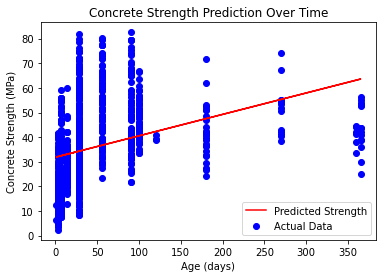

In [22]:
plt.plot(df['age'].values, model_age.predict(X_age), color='red', label='Predicted Strength')
plt.scatter(df['age'].values, df['strength'].values, marker='o', color='b', label='Actual Data')
plt.title('Concrete Strength Prediction Over Time')
plt.xlabel('Age (days)')
plt.ylabel('Concrete Strength (MPa)')
plt.legend()
plt.show()


<h2>Effects of Ingredients on Concrete Strength</h2>
What follows are a series of graphics to show the effects of each ingredient on the overall composition, strength and durability of concrete

In [23]:
#we list our ingredients to query
ingredients = ['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'coarseagg']
correlation_matrix_ingredients = df[ingredients + ['strength']].corr()

# Let's find the correlations between each ingredient and it's effect on concrete strength
correlations_with_strength = correlation_matrix_ingredients.loc['strength', ingredients]
print(correlations_with_strength)


cement          0.497832
slag            0.134829
ash            -0.105755
water          -0.289633
superplastic    0.366079
fineagg        -0.167241
coarseagg      -0.164935
Name: strength, dtype: float64


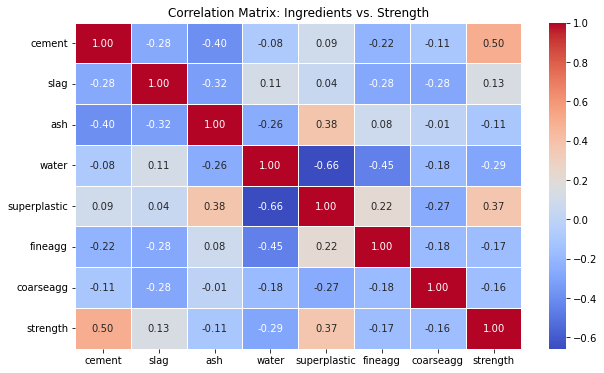

In [24]:
import seaborn as sns #to create our correlation matrix graphic

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_ingredients, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix: Ingredients vs. Strength')
plt.show()


In [25]:
from sklearn.linear_model import LinearRegression #To create comparitive calcualations

#define our ingredients to query
for ingredient in ingredients:
    X_ingredient = df[ingredient].values.reshape(-1, 1)
    y_strength = df['strength'].values

#create a regression model 
    model_ingredient = LinearRegression().fit(X_ingredient, y_strength)
    print(f"\nRegression Analysis for {ingredient}:")
    print("Ingredient Coefficient:", model_ingredient.coef_[0])
    print("Intercept:", model_ingredient.intercept_)



Regression Analysis for cement:
Ingredient Coefficient: 0.07958033584687198
Intercept: 13.44252811239992

Regression Analysis for slag:
Ingredient Coefficient: 0.026106166387625706
Intercept: 33.88882445591123

Regression Analysis for ash:
Ingredient Coefficient: -0.02760620385684696
Intercept: 37.313895788413646

Regression Analysis for water:
Ingredient Coefficient: -0.22658476489712795
Intercept: 76.95834096883587

Regression Analysis for superplastic:
Ingredient Coefficient: 1.023732975640061
Intercept: 29.46604592163058

Regression Analysis for fineagg:
Ingredient Coefficient: -0.034846959371793794
Intercept: 62.77488891188048

Regression Analysis for coarseagg:
Ingredient Coefficient: -0.035436848792762723
Intercept: 70.29514224732492


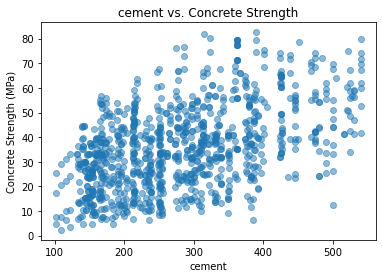

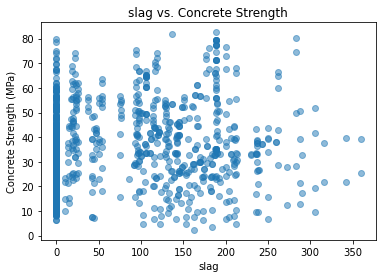

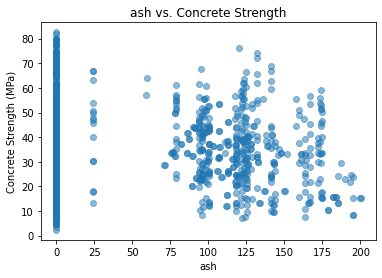

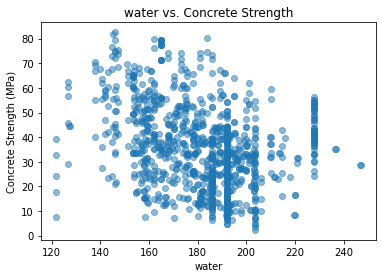

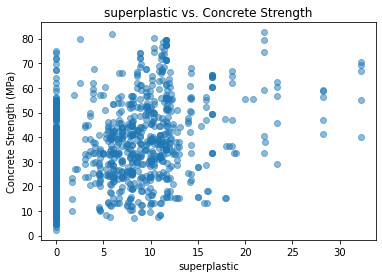

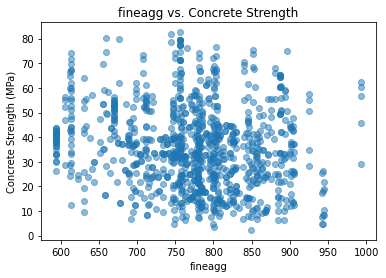

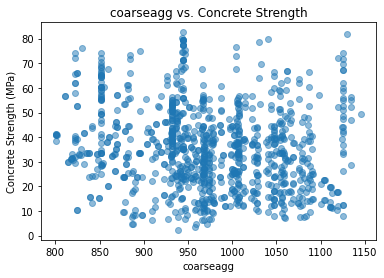

In [26]:
#Let's look at each ingredient and how it affects concrete strength
for ingredient in ingredients:
    plt.scatter(df[ingredient], df['strength'], alpha=0.5)
    plt.title(f'{ingredient} vs. Concrete Strength')
    plt.xlabel(ingredient)
    plt.ylabel('Concrete Strength (MPa)')
    plt.show()


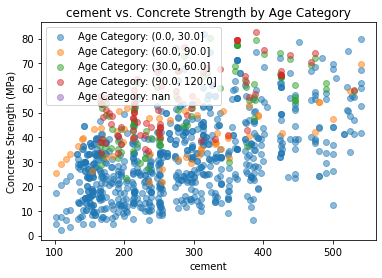

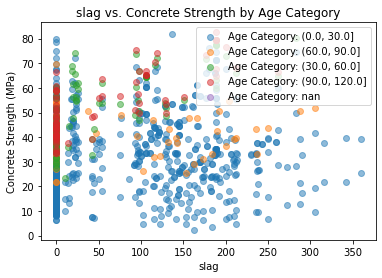

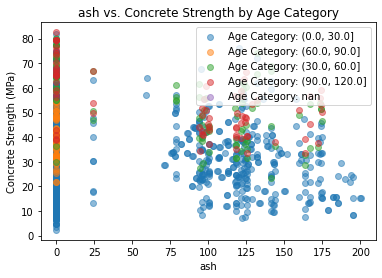

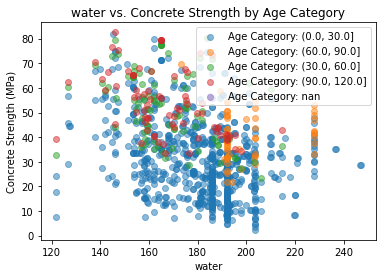

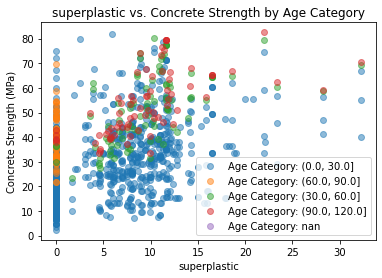

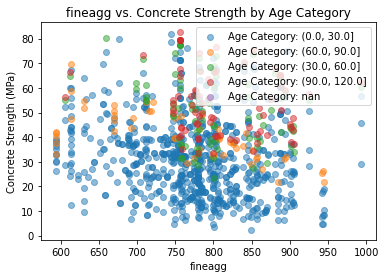

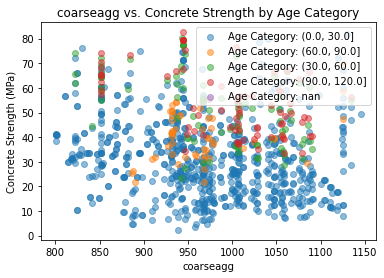

In [27]:
#Let's look at each ingredient and how age affects concrete strength
for ingredient in ingredients:
    for age_category in df['age_category'].unique():
        subset_data = df[df['age_category'] == age_category]
        plt.scatter(subset_data[ingredient], subset_data['strength'], alpha=0.5, label=f'Age Category: {age_category}')
    
    plt.title(f'{ingredient} vs. Concrete Strength by Age Category')
    plt.xlabel(ingredient)
    plt.ylabel('Concrete Strength (MPa)')
    plt.legend()
    plt.show()


In [28]:
#Let's calculate relationship variances in our ingredients
cv_by_ingredient = (df[ingredients].std() / df[ingredients].mean()).sort_values(ascending=False)
print("Coefficient of Variation by Ingredient:")
print(cv_by_ingredient)


Coefficient of Variation by Ingredient:
ash             1.181010
slag            1.167581
superplastic    0.962799
cement          0.371687
water           0.117610
fineagg         0.103643
coarseagg       0.079918
dtype: float64


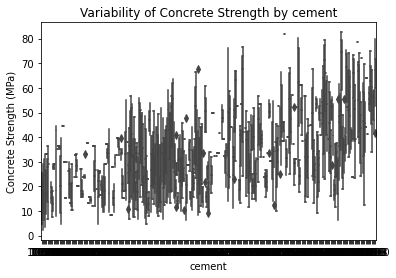

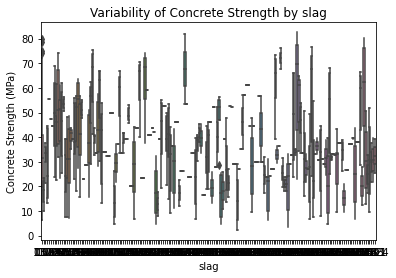

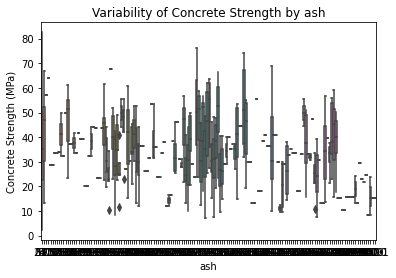

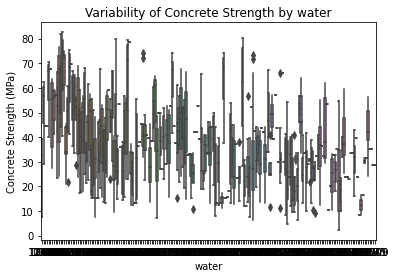

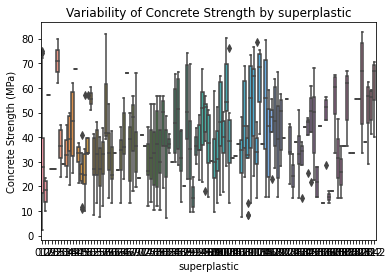

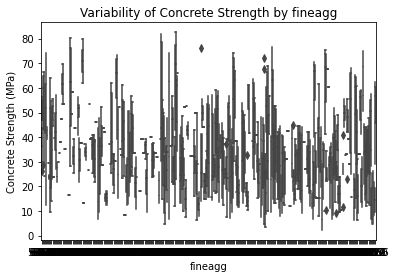

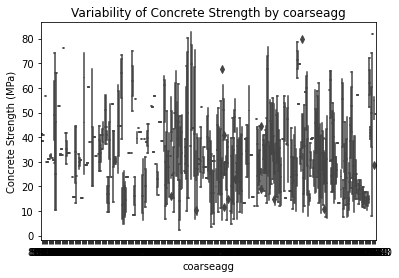

In [29]:
#Let's see how each ingredient can cause a variation in concrete strength
for ingredient in ingredients:
    sns.boxplot(x=ingredient, y='strength', data=df)
    plt.title(f'Variability of Concrete Strength by {ingredient}')
    plt.xlabel(ingredient)
    plt.ylabel('Concrete Strength (MPa)')
    plt.show()


In [30]:
from scipy.stats import f_oneway #let's test for variations in any of our ingredient values

for ingredient in ingredients:
    groups = [df[df[ingredient] == value]['strength'] for value in df[ingredient].unique()]
    f_statistic, p_value = f_oneway(*groups)
    print(f"\nANOVA Test for {ingredient}:")
    print("F-Statistic:", f_statistic)
    print("P-Value:", p_value)



ANOVA Test for cement:
F-Statistic: 3.58353392948005
P-Value: 1.6411591250642177e-43

ANOVA Test for slag:
F-Statistic: 2.8987533057489645
P-Value: 5.160503263114712e-25

ANOVA Test for ash:
F-Statistic: 0.9389593438504562
P-Value: 0.6837425042620296

ANOVA Test for water:
F-Statistic: 4.342746278829456
P-Value: 1.003404749650098e-49

ANOVA Test for superplastic:
F-Statistic: 3.9585760434450394
P-Value: 7.250205002662699e-31

ANOVA Test for fineagg:
F-Statistic: 2.787550319231389
P-Value: 3.44477993964229e-29

ANOVA Test for coarseagg:
F-Statistic: 2.933268025257336
P-Value: 2.2373618944993093e-31


In [31]:
consistency_metrics = df[ingredients].std()
print("Consistency Metrics:")
print(consistency_metrics)


Consistency Metrics:
cement          104.506364
slag             86.279342
ash              63.997004
water            21.354219
superplastic      5.973841
fineagg          80.175980
coarseagg        77.753954
dtype: float64


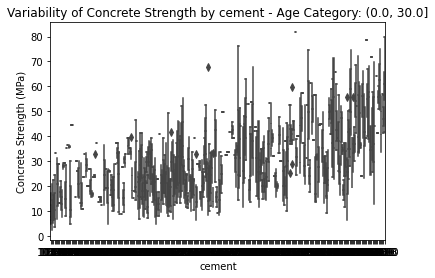

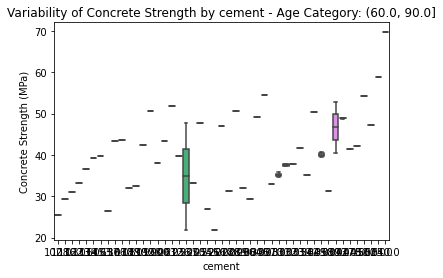

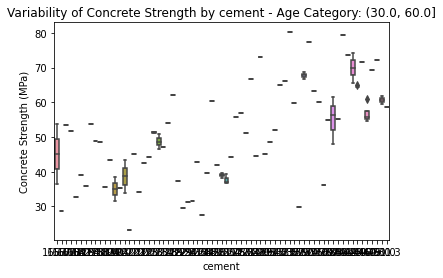

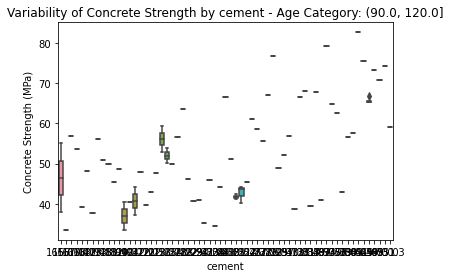

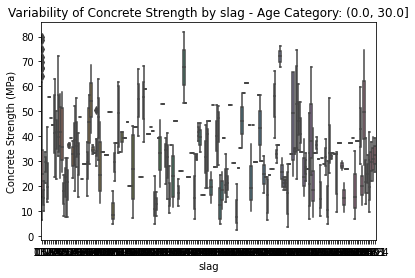

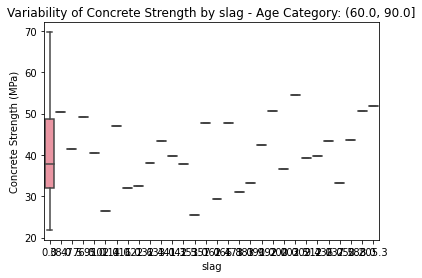

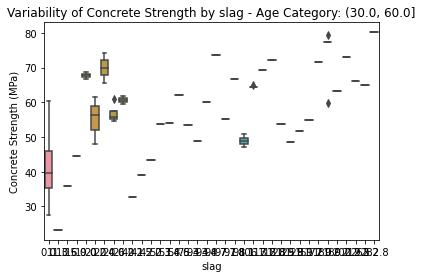

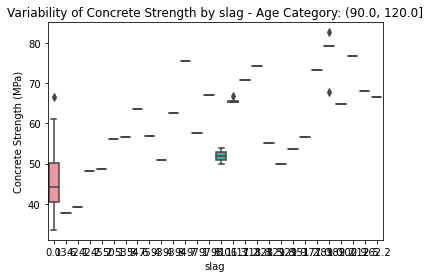

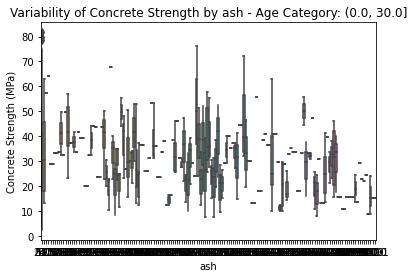

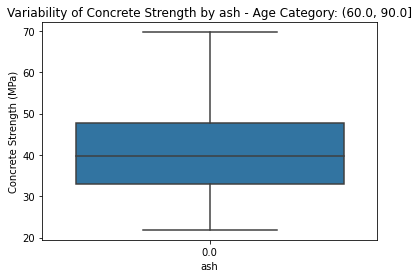

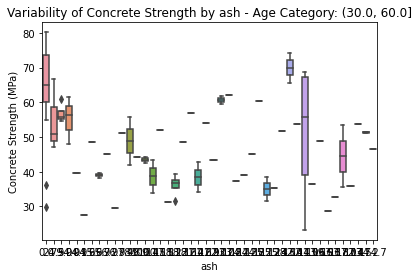

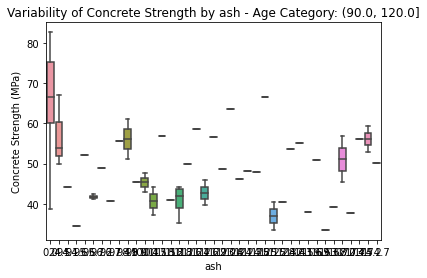

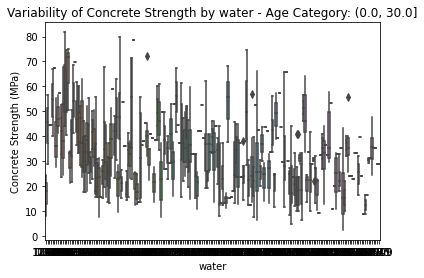

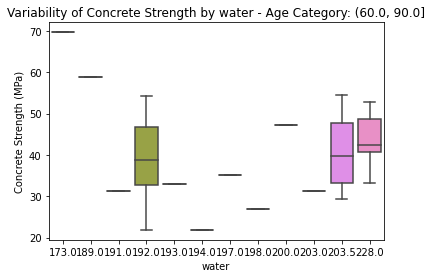

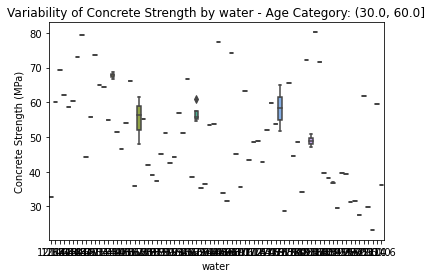

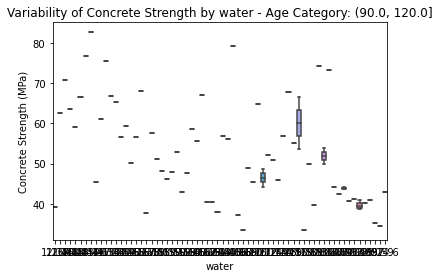

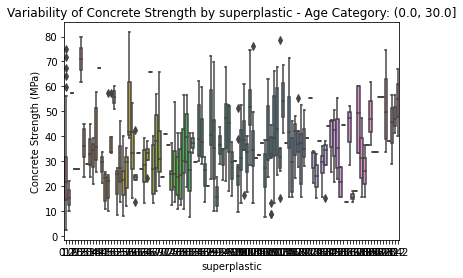

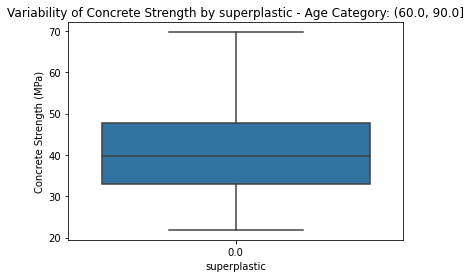

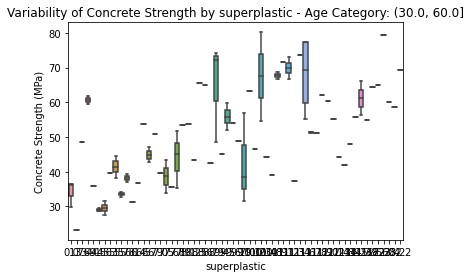

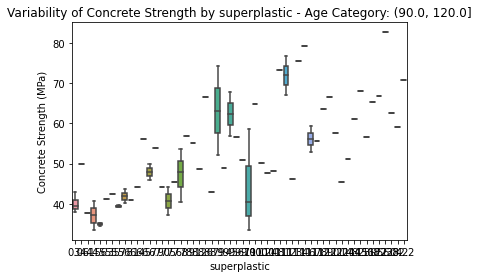

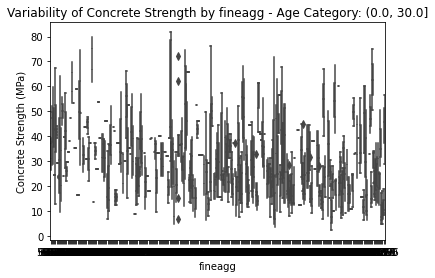

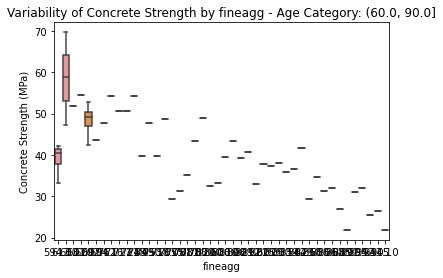

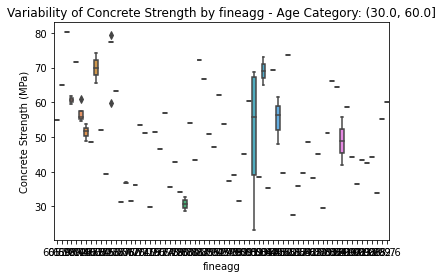

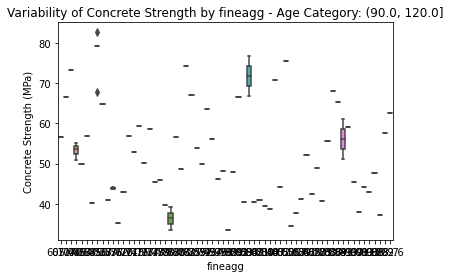

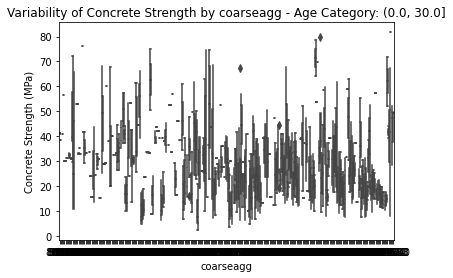

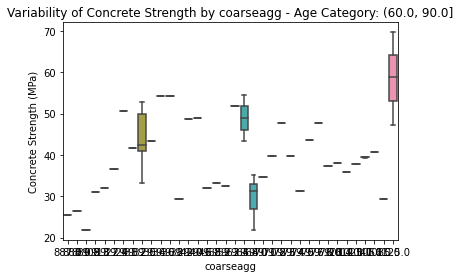

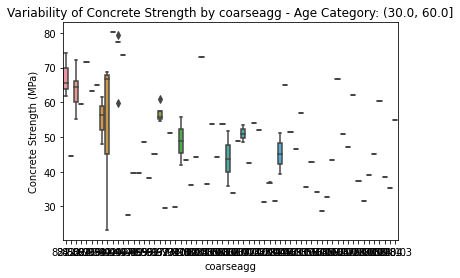

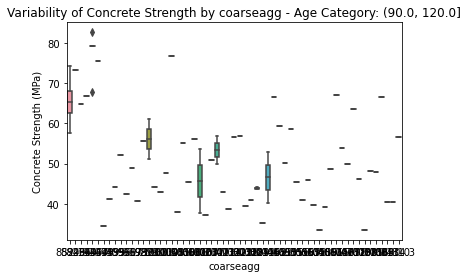

In [32]:
import seaborn as sns #to create advanced graphics
import matplotlib.pyplot as plt #to plot our charts

#our first variable to query against is age
for ingredient in ingredients:
    for age_category in df['age_category'].unique():
        subset_data = df[df['age_category'] == age_category]
        
# If there is data we'll compare each ingredint for age and the effect it has on strength over time
        if not subset_data.empty:
            sns.boxplot(x=ingredient, y='strength', data=subset_data)
            plt.title(f'Variability of Concrete Strength by {ingredient} - Age Category: {age_category}')
            plt.xlabel(ingredient)
            plt.ylabel('Concrete Strength (MPa)')
            plt.show()


In [33]:
import plotly.express as px

# Create a histogram for the distribution of cement amounts
fig = px.histogram(df, x='cement', nbins=20, title='Distribution of Cement Amounts',
                   labels={'cement': 'Cement Amount', 'count': 'Frequency'})
fig.show()


<h2>Slag & Ash</h2>
Slag and Ash are two waste products that are necessary for concrete production.  Let's have a look at their effects on concrete production

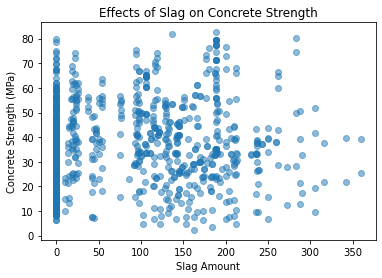

In [34]:
# Scatter plot for the effects of slag on concrete strength
plt.scatter(df['slag'], df['strength'], alpha=0.5)
plt.title('Effects of Slag on Concrete Strength')
plt.xlabel('Slag Amount')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


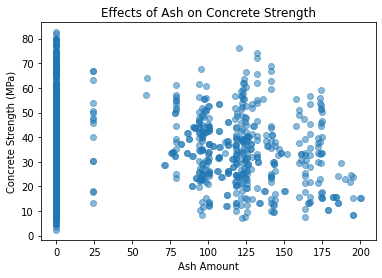

In [35]:
# Scatter plot for the effects of ash on concrete strength
plt.scatter(df['ash'], df['strength'], alpha=0.5)
plt.title('Effects of Ash on Concrete Strength')
plt.xlabel('Ash Amount')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


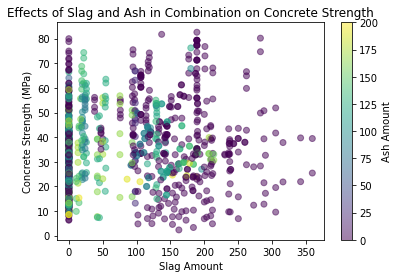

In [36]:
# Scatter plot for the effects of slag and ash in combination on concrete strength
plt.scatter(df['slag'], df['strength'], c=df['ash'], cmap='viridis', alpha=0.5)
plt.title('Effects of Slag and Ash in Combination on Concrete Strength')
plt.xlabel('Slag Amount')
plt.ylabel('Concrete Strength (MPa)')
plt.colorbar(label='Ash Amount')
plt.show()


In [37]:
from scipy.optimize import minimize #let's see what the most cost effective slag and ash ratios are for concrete strength

# Let's create our cost function to minimize
def cost_function(x):
    slag_ratio, ash_ratio = x
    
    return -df['strength'].corr(slag_ratio * df['slag'] + ash_ratio * df['ash'])

# Set constraints (optional) - ensure the ratios sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1})

# Initial guess for ratios
initial_guess = [0.5, 0.5]

# Minimize the negative correlation (maximize the positive correlation)
result = minimize(cost_function, initial_guess, constraints=constraints)

# Extract optimal ratios
optimal_slag_ratio, optimal_ash_ratio = result.x
print(f"Optimal Slag Ratio: {optimal_slag_ratio:.2f}")
print(f"Optimal Ash Ratio: {optimal_ash_ratio:.2f}")


Optimal Slag Ratio: 5.73
Optimal Ash Ratio: -4.73


<h2>Water and Concrete Production</h2>
Let's have a look at the effects of water on concrete production.  It might seem silly, but the ammount of water added does make a difference

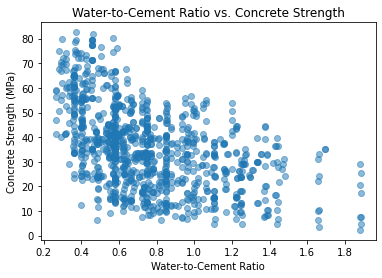

In [38]:
# Scatter plot for the water-to-cement ratio vs. strength
plt.scatter(df['water'] / df['cement'], df['strength'], alpha=0.5)
plt.title('Water-to-Cement Ratio vs. Concrete Strength')
plt.xlabel('Water-to-Cement Ratio')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


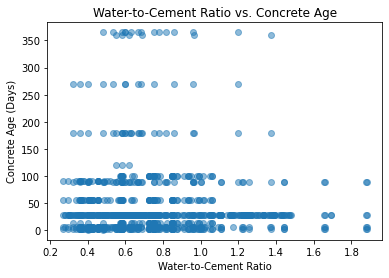

In [39]:
# Scatter plot for the water-to-cement ratio vs. age
plt.scatter(df['water'] / df['cement'], df['age'], alpha=0.5)
plt.title('Water-to-Cement Ratio vs. Concrete Age')
plt.xlabel('Water-to-Cement Ratio')
plt.ylabel('Concrete Age (Days)')
plt.show()


In [40]:
# What's the correlation between the water-to-cement ratio and strength
correlation_water_cement_strength = df['water'].corr(df['strength'] / df['cement'])
print(f"Correlation between Water-to-Cement Ratio and Strength: {correlation_water_cement_strength:.2f}")


Correlation between Water-to-Cement Ratio and Strength: -0.20


In [41]:
from sklearn.linear_model import LinearRegression #to run comparitive calculations

# Perform a regression analysis for water-to-cement ratio vs. strength
X_water_cement = (df['water'] / df['cement']).values.reshape(-1, 1)
y_strength = df['strength'].values

model_water_cement = LinearRegression().fit(X_water_cement, y_strength)
print("Water-to-Cement Ratio Coefficient:", model_water_cement.coef_[0])
print("Intercept:", model_water_cement.intercept_)


Water-to-Cement Ratio Coefficient: -26.63785112320368
Intercept: 55.750166416819965


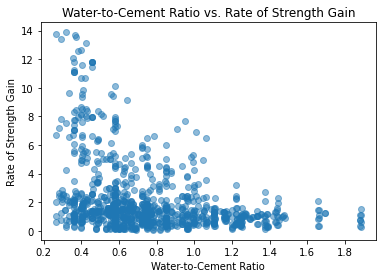

In [42]:
# Calculate the rate of strength gain over time
durability_metric = df['strength'] / df['age']

# Scatter plot for the water-to-cement ratio vs. rate of strength gain
plt.scatter(df['water'] / df['cement'], durability_metric, alpha=0.5)
plt.title('Water-to-Cement Ratio vs. Rate of Strength Gain')
plt.xlabel('Water-to-Cement Ratio')
plt.ylabel('Rate of Strength Gain')
plt.show()


<h2>Effects of Superplactisizers on Concrete Production</h2>
Let's see if adding superplasticizers to concrete makes it stronger or what effects it might have

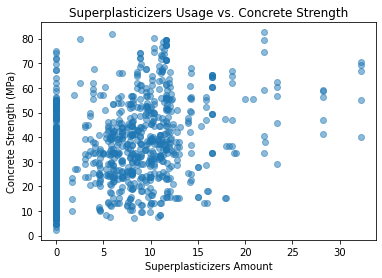

In [43]:
# Scatter plot for superplasticizers vs. strength
plt.scatter(df['superplastic'], df['strength'], alpha=0.5)
plt.title('Superplasticizers Usage vs. Concrete Strength')
plt.xlabel('Superplasticizers Amount')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


In [44]:
# What's the coefficient between superplasticizers and strength
correlation_superplastic_strength = df['superplastic'].corr(df['strength'])
print(f"Correlation between Superplasticizers Usage and Strength: {correlation_superplastic_strength:.2f}")


Correlation between Superplasticizers Usage and Strength: 0.37


In [45]:
from sklearn.linear_model import LinearRegression #to create comparitive calculations

# Perform a regression analysis for superplasticizers vs. strength
X_superplastic = df['superplastic'].values.reshape(-1, 1)
y_strength = df['strength'].values

model_superplastic = LinearRegression().fit(X_superplastic, y_strength)
print("Superplasticizers Coefficient:", model_superplastic.coef_[0])
print("Intercept:", model_superplastic.intercept_)


Superplasticizers Coefficient: 1.023732975640061
Intercept: 29.46604592163058


In [46]:
# Let's define our durability metric
df['durability'] = (df['age'] * df['strength']) / 100

# Let's create a scale of 0 to 100
max_durability = df['durability'].max()
df['durability'] = (df['durability'] / max_durability) * 100

# Display the updated DataFrame
print(df[['age', 'strength', 'durability']].head())


   age  strength  durability
0   28     29.89    4.084310
1   14     23.51    1.606258
2   28     29.22    3.992758
3   28     45.85    6.265159
4   28     18.29    2.499231


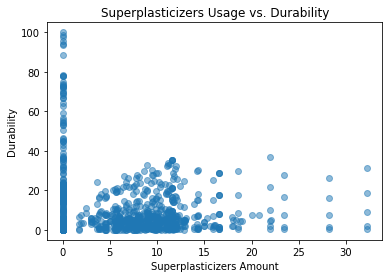

In [47]:
# Scatter plot for superplasticizers vs. durability
plt.scatter(df['superplastic'], df['durability'], alpha=0.5)
plt.title('Superplasticizers Usage vs. Durability')
plt.xlabel('Superplasticizers Amount')
plt.ylabel('Durability')
plt.show()


<h2>Coarse Aggregate vs Fine Aggregate</h2>
What effect do these ingredients have on the composition of concrete?

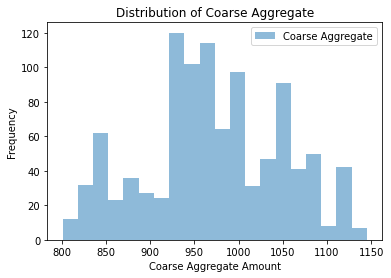

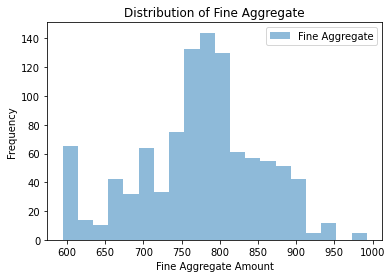

In [48]:
# Histogram for the distribution of coarse aggregate
plt.hist(df['coarseagg'], bins=20, alpha=0.5, label='Coarse Aggregate')
plt.title('Distribution of Coarse Aggregate')
plt.xlabel('Coarse Aggregate Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Histogram for the distribution of fine aggregate
plt.hist(df['fineagg'], bins=20, alpha=0.5, label='Fine Aggregate')
plt.title('Distribution of Fine Aggregate')
plt.xlabel('Fine Aggregate Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()


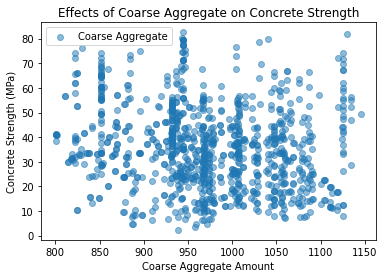

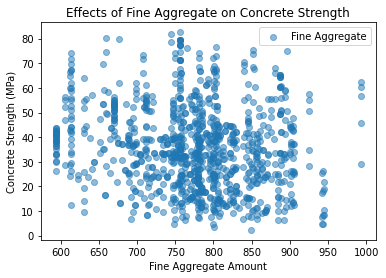

In [49]:
# Scatter plot for the effects of coarse aggregate on strength
plt.scatter(df['coarseagg'], df['strength'], alpha=0.5, label='Coarse Aggregate')
plt.title('Effects of Coarse Aggregate on Concrete Strength')
plt.xlabel('Coarse Aggregate Amount')
plt.ylabel('Concrete Strength (MPa)')
plt.legend()
plt.show()

# Scatter plot for the effects of fine aggregate on strength
plt.scatter(df['fineagg'], df['strength'], alpha=0.5, label='Fine Aggregate')
plt.title('Effects of Fine Aggregate on Concrete Strength')
plt.xlabel('Fine Aggregate Amount')
plt.ylabel('Concrete Strength (MPa)')
plt.legend()
plt.show()


In [50]:
# Calculate correlation coefficients
correlation_coarse_strength = df['coarseagg'].corr(df['strength'])
correlation_fine_strength = df['fineagg'].corr(df['strength'])

print(f"Correlation between Coarse Aggregate and Strength: {correlation_coarse_strength:.2f}")
print(f"Correlation between Fine Aggregate and Strength: {correlation_fine_strength:.2f}")


Correlation between Coarse Aggregate and Strength: -0.16
Correlation between Fine Aggregate and Strength: -0.17


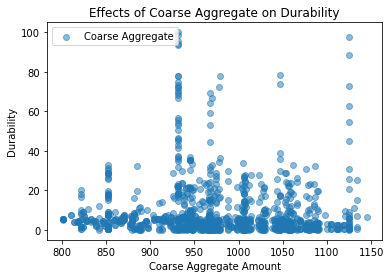

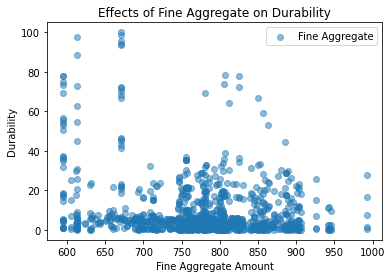

In [51]:
# Scatter plot for the effects of coarse aggregate on durability (replace with your durability metric)
plt.scatter(df['coarseagg'], df['durability'], alpha=0.5, label='Coarse Aggregate')
plt.title('Effects of Coarse Aggregate on Durability')
plt.xlabel('Coarse Aggregate Amount')
plt.ylabel('Durability')
plt.legend()
plt.show()

# Scatter plot for the effects of fine aggregate on durability (replace with your durability metric)
plt.scatter(df['fineagg'], df['durability'], alpha=0.5, label='Fine Aggregate')
plt.title('Effects of Fine Aggregate on Durability')
plt.xlabel('Fine Aggregate Amount')
plt.ylabel('Durability')
plt.legend()
plt.show()


<h2>Concrete Strength</h2>
Here we go over some strength related data again, but use different graphics and queries

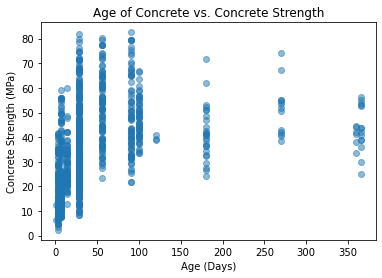

In [52]:
# Scatter plot for age vs. strength
plt.scatter(df['age'], df['strength'], alpha=0.5)
plt.title('Age of Concrete vs. Concrete Strength')
plt.xlabel('Age (Days)')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


In [53]:
# Let's see if there is a correlation between age and strength
correlation_age_strength = df['age'].corr(df['strength'])
print(f"Correlation between Age and Strength: {correlation_age_strength:.2f}")


Correlation between Age and Strength: 0.33


In [54]:
from sklearn.linear_model import LinearRegression #we'll perform comparison calculations

# Let's do a regression analysis for age vs. strength
X_age = df['age'].values.reshape(-1, 1)
y_strength = df['strength'].values

#show us the output
model_age_strength = LinearRegression().fit(X_age, y_strength)
print("Age Coefficient:", model_age_strength.coef_[0])
print("Intercept:", model_age_strength.intercept_)


Age Coefficient: 0.08697285387557797
Intercept: 31.84659488982895


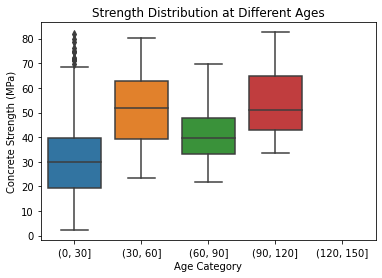

In [55]:
import seaborn as sns #use seaborn for our boxplots

# Box plot for strength distribution at different ages
sns.boxplot(x=df['age_category'], y=df['strength'])
plt.title('Strength Distribution at Different Ages')
plt.xlabel('Age Category')
plt.ylabel('Concrete Strength (MPa)')
plt.show()


In [56]:
import plotly.express as px #let's create line plots for the same query

# Line chart for strength development over time
fig = px.line(df, x='age', y='strength', title='Strength Development Over Time', labels={'age': 'Age (Days)', 'strength': 'Concrete Strength (MPa)'})

# Show the figure
fig.show()


In [57]:
import plotly.express as px #use plotly to plot our graphic

# Check for missing values in the 'age_category' column
print("Missing values in 'age_category':", df['age_category'].isnull().sum())

# Check unique values in the 'age_category' column
print("Unique values in 'age_category':", df['age_category'].unique())

# Remove rows with missing values in 'age_category'
df_cleaned = df.dropna(subset=['age_category'])

# Line chart for strength development over time within each age category
fig = px.line(df_cleaned, x='age', y='strength', color='age_category', title='Strength Development Over Time by Age Category', labels={'age': 'Age (Days)', 'strength': 'Concrete Strength (MPa)', 'color': 'Age Category'})

# Show the figure
fig.show()


Missing values in 'age_category': 59
Unique values in 'age_category': [(0.0, 30.0], (60.0, 90.0], (30.0, 60.0], (90.0, 120.0], NaN]
Categories (5, interval[int64, right]): [(0, 30] < (30, 60] < (60, 90] < (90, 120] < (120, 150]]


In [58]:
from sklearn.linear_model import LinearRegression #for comparison calculations

# Select relevant features and target to compare against
X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]
y = df['strength']

# Fit a multiple linear regression model
model = LinearRegression().fit(X, y)

# Print coefficients
print("Coefficients:")
print(dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)


Coefficients:
{'cement': 0.11980433449716325, 'slag': 0.10386580889910438, 'ash': 0.08793432154201249, 'water': -0.14991841906740364, 'superplastic': 0.292224595105558, 'coarseagg': 0.01808621482744334, 'fineagg': 0.02019035105301456, 'age': 0.11422206828938222}
Intercept: -23.33121358490346


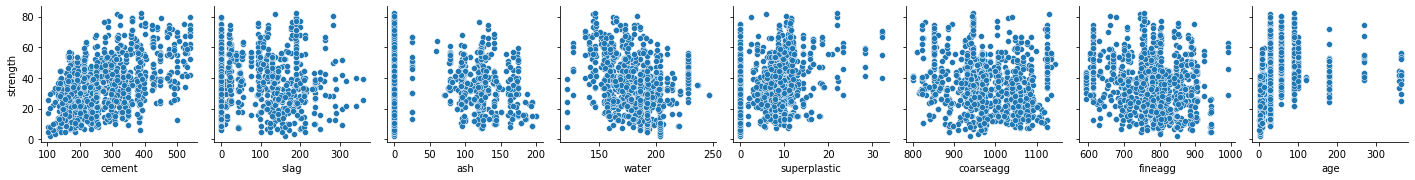

In [59]:
import seaborn as sns #to create our scatterplots

# Pairwise scatter plots for strength and individual components
sns.pairplot(df, x_vars=['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age'], y_vars=['strength'])
plt.show()


In [60]:
from sklearn.linear_model import LinearRegression #to run comparison calculations

# Select relevant features and target to compare against
X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]
y = df['strength']

# Fit a multiple linear regression model
model = LinearRegression().fit(X, y)

# Print coefficients
print("Coefficients:")
print(dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)


Coefficients:
{'cement': 0.11980433449716325, 'slag': 0.10386580889910438, 'ash': 0.08793432154201249, 'water': -0.14991841906740364, 'superplastic': 0.292224595105558, 'coarseagg': 0.01808621482744334, 'fineagg': 0.02019035105301456, 'age': 0.11422206828938222}
Intercept: -23.33121358490346


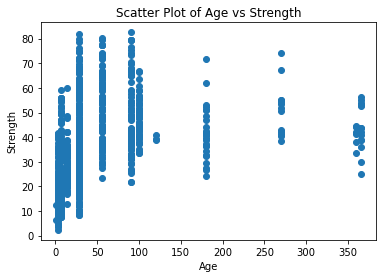

In [61]:
import matplotlib.pyplot as plt #to plot our graph

plt.scatter(df['age'], df['strength'])
plt.xlabel('Age')
plt.ylabel('Strength')
plt.title('Scatter Plot of Age vs Strength')
plt.show()


<h2>Let's Run Some Statistics</h2>
First we're going to check the average, center and standard deviations in our data, then we're going to see if there are any weird things going on with the data by running it through a statistical model

In [62]:
# Calculate mean, median, and standard deviation for each column
summary_statistics = df.describe().transpose()[['mean', '50%', 'std']]
summary_statistics.columns = ['mean', 'median', 'std']

# Display the summary statistics
print(summary_statistics)


                      mean        median           std
cement          281.167864    272.900000    104.506364
slag             73.895825     22.000000     86.279342
ash              54.188350      0.000000     63.997004
water           181.567282    185.000000     21.354219
superplastic      6.204660      6.400000      5.973841
coarseagg       972.918932    968.000000     77.753954
fineagg         773.580485    779.500000     80.175980
age              45.662136     28.000000     63.169912
strength         35.817961     34.445000     16.705742
cost_per_mix  82241.374126  80449.500000  15793.439906
durability        9.673699      4.506542     14.759436


Nothing too weird here! Let's have a look at the statistical model next.

In [63]:
import statsmodels.api as sm #to run statistical queries against our data

# Select our data columns
X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]

# Add a constant
X = sm.add_constant(X)

# Select the output
y = df['strength']

# Fit our model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          6.29e-206
Time:                        09:01:06   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -23.3312     26.586     -0.878   

We might have some issues with the statistical model trying to read a mix of numerical data and text data, but I'm not going to spend too much time dwelling on this, I think we've got enough data and information from this dataset already

<h2>Average Cement Content Vs Age & Strength!</h2>
The following interactive visual, takes cement content into consideration when considering age and strength to return values in the chart. Because the dataset is quite large, we've clustered the data to make the visual more attractive and less busy. 

In [64]:
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features_for_clustering = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age', 'strength']

# Standardize the features
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df[features_for_clustering]), columns=features_for_clustering)

# Choose the number of clusters (you may need to adjust this based on your dataset)
n_clusters = 3

# Fit K-means clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df_standardized)

# Create a scatter plot to visualize the clusters
fig = px.scatter_3d(df, x='cement', y='strength', z='age', color='cluster', title='Clustering of Concrete Data', labels={'cement': 'Cement', 'strength': 'Strength', 'age': 'Age'}, opacity=0.7)
fig.show()


<h2>Which is the most important ingredient in Concrete?</h2>
It should be pretty obvious, but let the data do the talking.

In [65]:
import plotly.express as px #plotly helps us plot the data for the graph
from sklearn.inspection import permutation_importance #helps us determine importance
from sklearn.model_selection import train_test_split #we use ML to learn and return answers
from sklearn.linear_model import LinearRegression #linearregression helps us define values in the data

# Select the features and target variable to compare against
features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']
target = 'strength'

#what are we comparing?
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Create a bar plot to visualize feature importance
fig = px.bar(x=features, y=perm_importance.importances_mean, error_y=perm_importance.importances_std, title='Permutation Importance for Concrete Strength Prediction', labels={'x': 'Feature', 'y': 'Importance'})
fig.show()


<h2>Are there any unusual values?</h2>
I use python to go through each column and row to look for unusual values and plot each of these in a graph for each ingredient to follow.

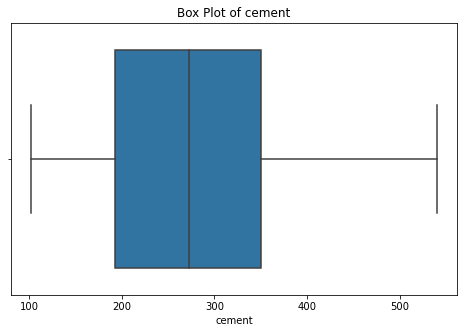

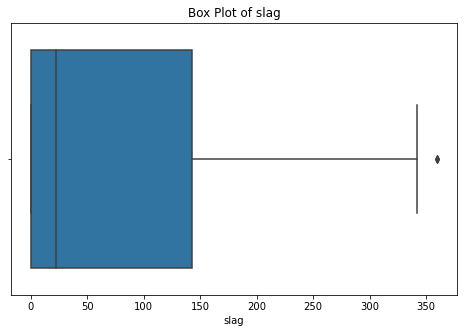

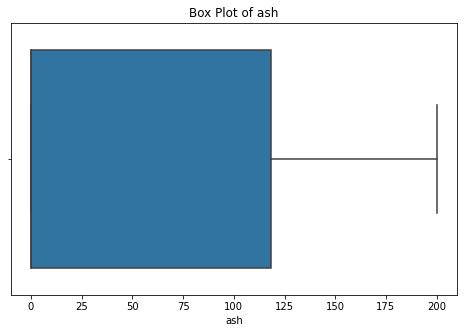

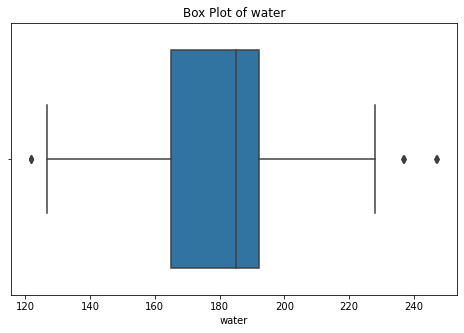

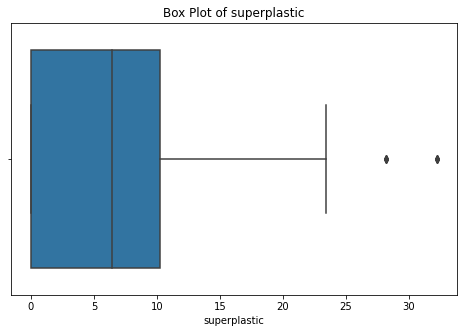

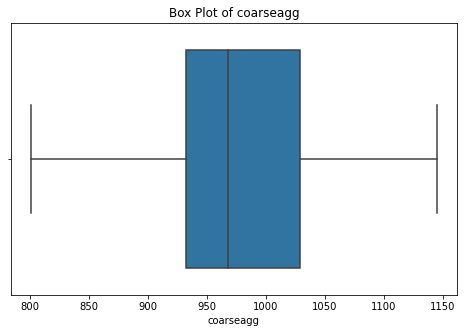

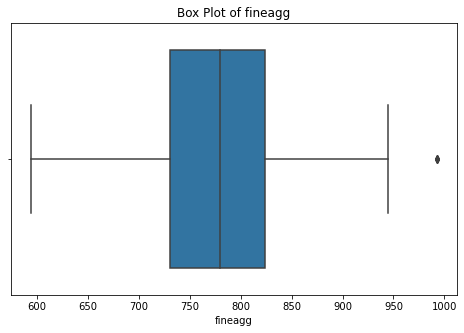

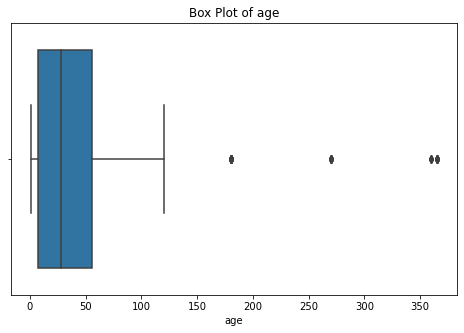

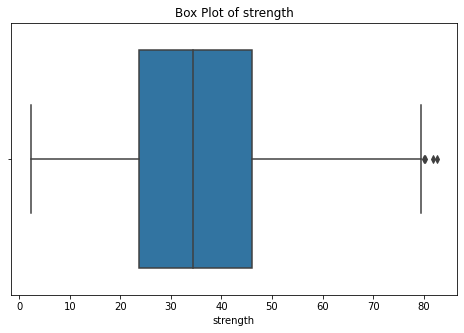

In [66]:
import seaborn as sns #for graphic effects
import matplotlib.pyplot as plt #to plot the data

# Create box plots for each numbered column
numeric_columns = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age', 'strength']
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()


In [67]:
from scipy.stats import zscore #this helps us give a value to compare our data against

# Calculate z-scores for each numeric column
z_scores = np.abs(zscore(df[numeric_columns]))

# I set a threshold to identify outliers
threshold = 3
outlier_indices = np.where(z_scores > threshold)

# Print the indices of outliers
print("Indices of outliers:", outlier_indices)


Indices of outliers: (array([  21,   44,   64,   66,  133,  149,  156,  157,  159,  198,  232,
        256,  262,  263,  270,  292,  297,  313,  323,  361,  393,  448,
        465,  484,  538,  564,  570,  601,  623,  632,  713,  720,  744,
        754,  755,  816,  838,  850,  878,  901,  918,  919,  951,  955,
        957,  990,  995, 1026, 1028], dtype=int32), array([1, 4, 7, 3, 7, 7, 4, 7, 7, 7, 4, 7, 7, 3, 7, 4, 7, 7, 7, 7, 7, 7,
       7, 7, 4, 1, 7, 7, 7, 7, 7, 7, 4, 7, 7, 4, 4, 7, 7, 7, 1, 7, 7, 4,
       7, 1, 7, 4, 7], dtype=int32))


In [68]:
# Calculate the IQR for each numeric column
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using Tukey's method
outlier_indices_tukey = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Print the indices of outliers detected by Tukey's method
print("Indices of outliers detected by Tukey's method:", df[outlier_indices_tukey].index)


Indices of outliers detected by Tukey's method: Index([  44,   51,   64,   66,   93,   99,  103,  129,  133,  144,  149,  152,
        156,  157,  159,  192,  198,  199,  207,  232,  256,  262,  263,  270,
        292,  297,  302,  312,  313,  323,  359,  361,  370,  393,  432,  447,
        448,  462,  465,  484,  504,  538,  539,  570,  581,  584,  587,  594,
        601,  620,  622,  623,  632,  642,  696,  713,  720,  721,  732,  740,
        744,  754,  755,  776,  789,  816,  826,  838,  850,  857,  861,  878,
        900,  901,  914,  918,  919,  950,  951,  955,  957,  971,  985,  990,
        995, 1003, 1017, 1026, 1028],
      dtype='int64')


<h2>Plot all the outliers</h2>
Now that all the unusual values have been established, let's plot them into separate graphics.


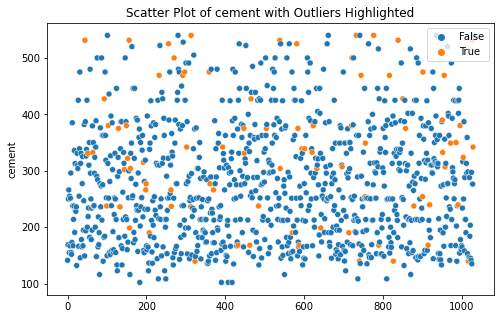

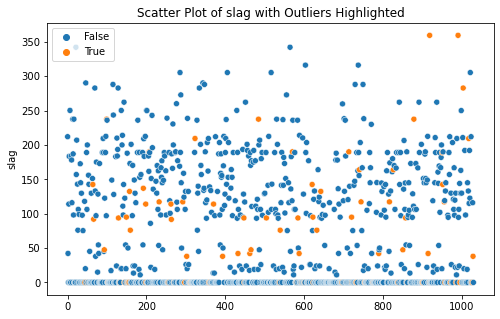

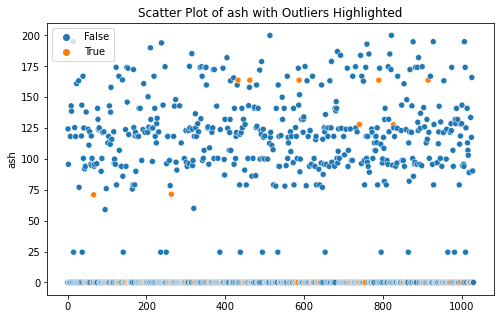

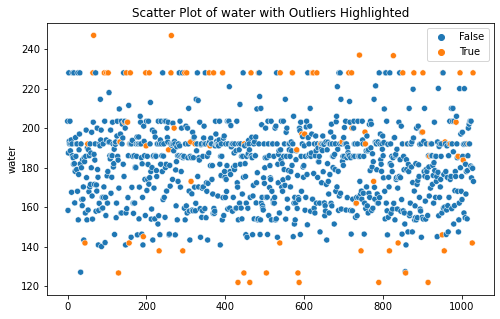

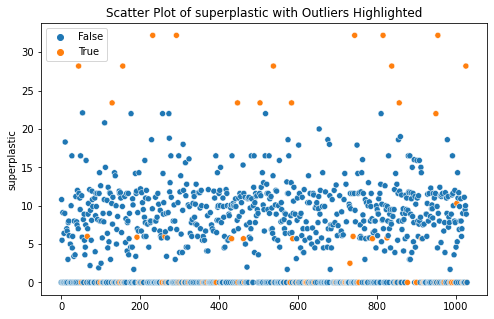

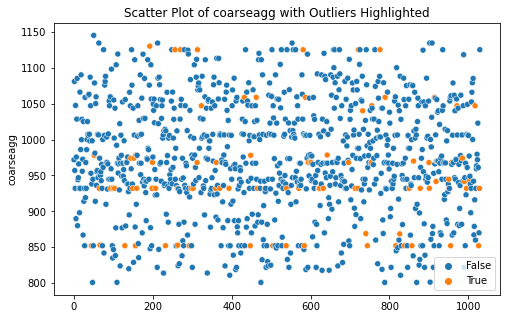

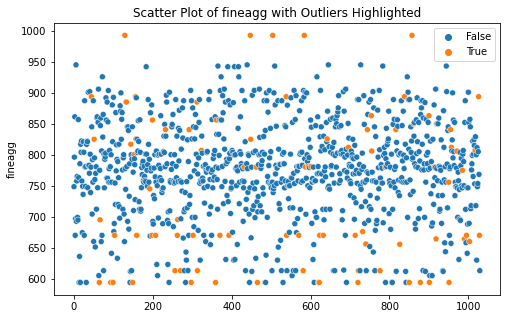

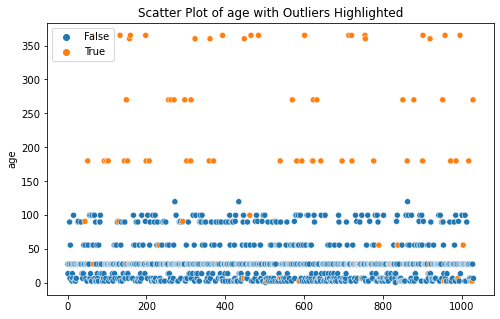

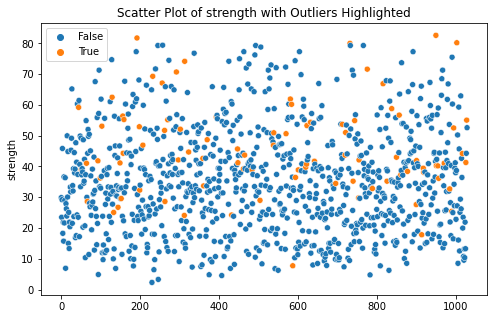

In [69]:
# Create scatter plots with identified outliers highlighted
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df.index, y=df[column], hue=outlier_indices_tukey)
    plt.title(f'Scatter Plot of {column} with Outliers Highlighted')
    plt.show()


<h2>Let's Classify Each Type Of Concrete</h2>
Concrete comes in 3 strengths - standard "NSC", hard "HSC" and Ultra hard "UHSC" - see the table below to see the Classification column added

In [70]:
import pandas as pd #to manipulate the data

# From our Data, we query the 'strength' column

# We add a new column 'Classification' based on the strengths mentioned above
df['Classification'] = pd.cut(df['strength'], bins=[20, 40, 80, float('inf')], labels=['NSC', 'HSC', 'UHSC'])

# Print the header and first 5 rows
print(df.head())


   cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  cost_per_mix cost_category age_category  durability  cluster  \
0     29.89      66274.65           NaN      (0, 30]    4.084310        1   
1     23.51      79214.15           NaN      (0, 30]    1.606258        0   
2     29.22      73906.00           NaN      (0, 30]    3.992758        0   
3     45.85      69200.00           NaN      (0, 30]    6.265159        1   
4     18.29      76731.95           NaN      (0, 30]    2.499231        1   

  Classification  
0            NSC  
1            NSC  
2            NSC  
3            HSC  
4  

<h2>Push changes to database</h2>
I've made a couple of changes, let's update the database

In [73]:
import pandas as pd #to manipulate data
import sqlite3 #to connect to DB

# Read the CSV file
concrete_file = 'concrete.csv' #path to my csv file
df = pd.read_csv(concrete_file)

# Connect to SQLite database
concretedatabase = 'C:/sqlite/concretedatabase.db'  #path to my database
conn = sqlite3.connect(concretedatabase)

# Write the DataFrame to a SQLite table
df.to_sql('concrete', conn, index=False, if_exists='replace')

# Verify the data has been imported successfully
query = "SELECT * FROM concrete LIMIT 5;"  # Fetch the first 5 rows
result = pd.read_sql_query(query, conn)
print(result)

# Close the connection
conn.close()


   cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29  


<h2>Modify Column Data Types</h2>
I have to ensure that my data is in the right format and that the columns are able to receive the data too.  The third and second last columns need to accept numbers(decimals) called "REAL" and the final column will receive Text, let's code the changes

In [74]:
import sqlite3

# Connect to the SQLite database
concretedatabase = 'C:/sqlite/concretedatabase.db'
conn = sqlite3.connect(concretedatabase)

# Add the new columns to the 'concrete' table
alter_table_queries = [
    "ALTER TABLE concrete ADD COLUMN cost_per_mix REAL;",
    "ALTER TABLE concrete ADD COLUMN durability REAL;",
    "ALTER TABLE concrete ADD COLUMN classification TEXT;"
]

try:
    # Execute the ALTER TABLE queries to add new columns
    for query in alter_table_queries:
        conn.execute(query)

    # Commit the changes
    conn.commit()

except Exception as e:
    # Print any errors that occurred
    print(f"Error during ALTER TABLE: {e}")

finally:
    # Close the connection
    conn.close()



<h2>Done! Time to update the Database</h2>
I need to ensure the last 3 columns I created are added to my database to show the results of all the calculations I ran

In [81]:
import sqlite3

# Connect to the SQLite database
concretedatabase = 'C:/sqlite/concretedatabase.db'
conn = sqlite3.connect(concretedatabase)

# Update the 'cost_per_mix', 'durability', and 'classification' columns in the 'concrete' table
update_query = """
UPDATE concrete
SET 
    cost_per_mix = cement * 130.00 + slag * 120.00 + ash * 110.00 + water * 500.00 + superplastic * 1300.00 + fineagg * 13.00 + coarseagg * 13.00,
    durability = age * (1 - strength / 100),
    classification = (
        CASE
            WHEN strength >= 20 AND strength < 40 THEN 'NSC'
            WHEN strength >= 40 AND strength < 80 THEN 'HSC'
            WHEN strength >= 80 THEN 'UHSC'
        END
    );
"""

try:
    # Execute the update query
    conn.execute(update_query)

    # Commit the changes
    conn.commit()

except Exception as e:
    # Print any errors that occurred
    print(f"Error during update: {e}")

finally:
    # Close the connection
    conn.close()


<h2>Let's verify!</h2>
Yes, the new columns are there.

In [82]:
# Connect to the SQLite database
conn = sqlite3.connect(concretedatabase)

# Select the first few rows to verify the changes
query = "SELECT * FROM concrete LIMIT 5;"
result = pd.read_sql_query(query, conn)
print(result)

# Close the connection
conn.close()


   cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  cost_per_mix  durability classification  
0     29.89      167922.9     19.6308            NSC  
1     23.51      158285.0     10.7086            NSC  
2     29.22      167512.3     19.8184            NSC  
3     45.85      183086.0     15.1620            HSC  
4     18.29      173285.3     22.8788           None  


<h2>Using ML to replace NULL Values with Average Values</h2>
I had a peek at my database in DBeaver and the last column "classification" was missing some values (had NULL) values, so I trained an ML model to replace the "NULL" values with average values that it calculated from each row. "I don't like having missing values"

In [86]:
import sqlite3 #to connect to DB
import pandas as pd #to create dataframes
from sklearn.linear_model import LogisticRegression #to create statistic models
from sklearn.compose import ColumnTransformer #to help create the calculations and reform the classification column
from sklearn.pipeline import Pipeline #used to iterate through the data and link it all
from sklearn.preprocessing import StandardScaler #to find variables in the data to address and unify the data

# Connect to the SQLite database
concretedatabase = 'C:/sqlite/concretedatabase.db'
conn = sqlite3.connect(concretedatabase)

# Read the data from the 'concrete' table
query = "SELECT * FROM concrete;"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Separate data into features (X) and target (y)
X = df.drop(['classification'], axis=1)
y = df['classification']

# Identify missing values to replace with concrete classifications
missing_values = X.isnull().sum().sum() + y.isnull().sum()

# Print the number of available samples for training and check for missing values
print(f"Number of available samples for training: {X.shape[0]}")
print(f"Number of missing values: {missing_values}")

# Check if there are enough samples for training and no missing values
if X.shape[0] > 1 and missing_values == 0:
    try:
        # Create a column transformer with standard scaling
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), X.columns)
            ],
            remainder='passthrough'
        )

        # Create a logistic regression model with liblinear solver
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(multi_class='auto', solver='liblinear', max_iter=1000))
        ])

        # Print the shape of the features before fitting
        print("Shape of features before fitting:", X.shape)

        # Fit the model
        model.fit(X, y)

        # Print success message
        print("Model trained successfully.")

    except Exception as e:
        print(f"Error during model training: {e}")

else:
    print("Not enough samples or missing values for training.")


Number of available samples for training: 1030
Number of missing values: 0
Shape of features before fitting: (1030, 11)
Model trained successfully.
